In [1]:
import random
import numpy as np
import pandas as pd

This implementation does the following to initialize a network:
1. Generates N nodes with some belief values between -bmax and bmax
2. Gives each node some amount of persuasion power between 0 and pmax
3. Connects these nodes to each other, at various rates

The number of positive-belief and negative-belief nodes is decided by some ratio.

We randomly generate & concatenate two arrays, one of positive integer values and one of negative integer values, with their lengths equivalent to the ratios. 

Then, they are shuffled.

When we define how nodes are connected, it is helpful for the first node to always be positive. Because the actual direction of belief is arbitrary, we flip the sign of all nodes if the first node is initialized as negative.

Lastly, we reshape the array of belief values into a nxn square matrix, where n*n = N.

In [2]:
def generateBelief(N, bmax, ratio):
    
    # Create skeptics and alarmists based on ratio (% that are skeptics)
    skeptics = np.array(random.choices(range(1, bmax), k = round(N * ratio)))
    alarmists = np.negative(random.choices(range(1, bmax), k = round(N * (1 - ratio))))

    d = np.concatenate((skeptics, alarmists))
    
    
    # Shuffle the nodes, so they are randomly distributed
    np.random.shuffle(d)

    # If the first node ends up being -1, flip all node beliefs
    # This is just to define our belief as:
    # "those who agree with the first node" (skeptic) vs "those who disagree" (alarmist)
    if d[0] < 0:
        
        d = np.negative(d)
    
    else:
        
        d = np.array(d)

    # We like to think of the nodes as a matrix, so we turn it into a square
    # If N is not a square number, this may become a problem.
    d = np.reshape(d.astype(float), [int(N**(1/2)), int(N**(1/2))])
    
    return d

In [3]:
d = generateBelief(100, 6, .50)

In [4]:
print(d)

[[ 5.  2.  2. -2. -4. -4. -5.  2.  2. -1.]
 [-5.  1.  5. -5. -3. -3. -3. -3. -5. -3.]
 [ 3.  4.  5. -3.  2. -2.  1.  5. -4.  4.]
 [ 3. -5. -3.  3.  5.  1. -1.  3. -2. -2.]
 [-1.  2. -5.  3. -4. -4. -3. -5.  1. -5.]
 [ 1. -1. -3. -5. -2. -3.  1. -1.  5.  1.]
 [ 4.  5.  2. -3.  2. -3. -3. -1. -3.  3.]
 [-4.  3. -4.  3. -1.  1. -3.  2.  3.  1.]
 [-1.  5.  1.  1.  1.  2. -4.  5.  2.  2.]
 [ 2.  1. -3.  4. -1. -1. -5. -3.  1.  3.]]


Similar to belief, we need to assign a persuation power to each node.

However, all nodes (regardless of belief) have an integer persuasion value that is between 0 and some maximum, pmax.

This is also reshapes to an nxn matrix.

In [72]:
def generatePersuasion(N, pmax):
    
    # Generates a random string of persuasion values between 0 and pmax
    p = random.choices(range(0, pmax + 1), k = N)
    
    # We like to think of the nodes as a matrix, so we turn it into a square
    # If N is not a square number, this may become a problem.
    p = np.reshape(np.array(p, dtype=float), [int(N**(1/2)), int(N**(1/2))])
    
    return p

In [73]:
p = generatePersuasion(100, 6)

In [74]:
print(p)

[[5. 0. 2. 0. 1. 3. 3. 4. 0. 1.]
 [2. 6. 6. 0. 2. 1. 2. 6. 2. 0.]
 [3. 2. 0. 1. 0. 1. 5. 0. 0. 4.]
 [0. 2. 4. 2. 0. 3. 6. 0. 4. 3.]
 [6. 3. 5. 0. 2. 1. 6. 1. 0. 4.]
 [5. 4. 1. 1. 5. 3. 0. 3. 0. 6.]
 [5. 2. 4. 0. 3. 3. 3. 0. 2. 4.]
 [6. 1. 3. 2. 0. 0. 6. 6. 4. 2.]
 [6. 5. 2. 1. 1. 6. 3. 6. 5. 0.]
 [2. 0. 3. 3. 4. 0. 5. 1. 0. 2.]]


Finally, we create the connection matrix.

The connection matrix is a NxN matrix, where the element at mxn corresponds to whether node m and node n are connected to each other.
1. If the element (m, n) = 1, then m and n are connected and have the same sign
2. If the element (m, n) = -1, then m and n are connected but have opposite signs
3. If the element (m, n) = 0, then m and n are not connected
4. If m = n, then (m, n) = 1 (nodes are connected in agreement to themselves)

We start by creating a NxN identity matrix, corresponding to the belief matrix. This is our connection matrix.

We first assume that all nodes in the network are connected (ie. the network is complete), and set values in the connection matrix to 1 or -1 (as appropriate), depending on their belief values.

In the edge case where belief is 0, we treat it as positive. No nodes are initialized with 0 belief, though it is theoretically possible (but unlikely) to have 0 belief in some models.

We do not actually assume that networks are fully connected. To create a partially-unconnected network, we choose random connections (elements) in the connection matrix and "break" them (set them to zero).

If we "break" the mxn element, we also break the nxm element. We break connections (edges) at a rate arate for positive connections and erate for negative connections.

In the case that we wish to preserve which connections are broken, we can pass in a variable old_breaks. Instead of randomly breaking connections, these connections will be broken instead.

In [8]:
def computeC(d, old_breaks, arate, erate):
    
    
    C1 = np.eye(d.size) # create the initial identity matrix of connections
                       # based on provided persuasion strength values
    
    disp = d.flatten()
    
    # This basically makes it so the sign of 0 is 1, instead of 0
    
    C1[0] = np.sign(disp) + (disp == 0)
    C1[:, 0] = np.sign(disp) + (disp == 0)
        
    for i in range(1, d.size):
        
        for k in range(1, d.size):

            C1[i, k] = np.sign(1 + (2 * np.sign(disp[i]) * np.sign(disp[k])))
            #C1[i, k] = 1 + ((disp[i] == 0) * (disp[k] == 0)) - (2 * abs((disp[i] == 0) * (disp[k] == 0)))
            
            #C1[i, k] = (np.sign(disp[i]) + (disp[i] == 0)) * (np.sign(disp[k]) + (disp[k] == 0))
    
    # If desired connections are being fed into the function, don't bother generating random ones
    if len(old_breaks) > 0:
        
        breaks = old_breaks
    
    # If no desired connections specified, break connections according to the arate and erate
    else:
        
        # Indices of elements in the upper triangle, minus the diagonal
        
        utnd = np.triu_indices_from(C1, k=1)
        
        # Indices of elements that are in agreement (allies)
        
        allies = np.where(C1 == 1)
        
        # Indices of elements that are allies and in the upper triangle
        
        upper_allies = set(zip(*utnd)) & set(zip(*allies))
        
        # Indices of elements that are enemies and in the upper triangle
        
        enemies = np.where(C1 == -1)
        
        upper_enemies = set(zip(*utnd)) & set(zip(*enemies))
        
        # Randomly select int(len(allies) * (1 - arate)) to break
    
        ally_breaks = random.sample(list(upper_allies), round(len(upper_allies) * (1 - arate)))
        
        enemy_breaks = random.sample(list(upper_enemies), round(len(upper_enemies) * (1 - erate)))

        breaks = ally_breaks + enemy_breaks
    
    for i in breaks:
        
        C1[i[0], i[1]] = 0
        C1[i[1], i[0]] = 0
    
    return C1

In [9]:
C = computeC(d, [], .3, .3)

In [10]:
print(C)

[[ 1.  0.  0. ...  0.  1.  1.]
 [ 0.  1.  0. ... -1.  0.  0.]
 [ 0.  0.  1. ...  0.  1.  0.]
 ...
 [ 0. -1.  0. ...  1.  0.  0.]
 [ 1.  0.  1. ...  0.  1.  0.]
 [ 1.  0.  0. ...  0.  0.  1.]]


Next, we define our models. The two models below do the following:

1. Model 0: Each node divides its persuasion power by the number of nodes connected to it (except itself), then "sends" that persuasion value to those nodes. The value is added to their belief.
2. Model 1: Each node divides its persuasion power by the number of enemy (opposite sign) nodes connected to it, then "sends" that persuasion value to those nodes. The value is added to their belief.

In both cases, each node acts according to how the network initialized, not their "running total" belief.

For example, if nodes 0 and 1 are positive and node 2 is negative, node 0 will send persuasion to node 2. If this flips node 2 from negative to positive, node 1 will not "know" this and will also send persuasion to node 2. 

Model 0, in detail:

1. Accept the matrices of belief, persuasion values, and connections. We also focus on a node n.
2. Create copies of the original persuasion & belief matrices. This way, we can keep the original beliefs and the current running total of beliefs separate.
3. Look at the number of connections to our current node. If there are none, we immediately stop.
4. Calculate how much persuasion is going to be sent. In this case, we divide the persuasion of our current node n by the connections to node n. The number of connections is equal to the sum of the nth row of the connection matrix, minus one (the connection to itself).
5. The persuasion sent should be in the direction of node n's belief, so we multiply the value from the previous step by the sign of node n's belief.
6. We iterate over each connection to node n, adding our persuasion increment ("flow") to each of those connected nodes. We also subtract that increment from node n's available persuasion.
7. Finally, we pass the new belief matrix back into the function that generates/updates our connection matrix. This updates where connections have become friendly or adversarial.

In [19]:
def model0(C, d, p, n):

    connections = (C[n] != 0).sum() - 1 # Obtain the number of connections
                                        # made to the nth node        
                                        
    #print('There are', connections, 'nodes connected to prime node', n)
                                        
    # Python lists are mutable, so we need to make copies to avoid changing original lists
    
    d1 = d.copy()
    p1 = p.copy()
                                        
    # If there are no connections to the prime node n, abort
    
    if connections == 0:
        
        #print('There are no connections to this node!')
        
        return C, d, p
    
    # Calculate how much persuasion will be sent to connections

    flow = np.sign(d1.flat[n]) * (p1.flat[n] / connections) # Per Model 0, divide 
                                 # the persuasion power by the # of connections
                                 # to the persuader. Multiply by the sign (so, flow gets negative values if neg opinion)
                                 
    #print('Our prime node has', p1.flat[n], 'persuasion to send. It will give', flow, 'to each node.')
    
    # For every node, if there is a connection to the prime node BUT
    # that node isn't the prime node itself, send flow amount to that node
    # and expend it from the prime node's persuasion
    
    for i in range(len(C)):
        
        if i != n and C[n, i] != 0:
            
            #print('Prime node', n, 'sending', flow, 'to node', i, 'which has', d1.flat[i], 'belief.')

            d1.flat[i] += flow
            p1.flat[n] -= flow
            
            #print('Node', i, 'now has', d1.flat[i], 'belief.')



    # Recalculate C depending on changes to d (ie. if node belief is flipped)
            
    C1 = computeC(d1, np.transpose(np.where(C == 0)), 0, 0)
    

        
    return C1, d1, p1

The function runmodel implements Model 0 or Model 1 over a course of runs. It also initializes the network using N (number of nodes) and ratio (number of positive compared to negative nodes).

It creates a copy of the belief matrix called grand_d. This is the running total of belief, which is kept separate from the initialized belief values because those initialized values is what the nodes base their decisions on.

In [4]:
def runmodel(model, runs, N, ratio):

    total_consensus = 0
    
    for j in range(runs):
    
        d = generateBelief(N, 6, ratio)
        C = computeC(d, [], .3, .3)
        p = generatePersuasion(N, 6)
        
        grand_d = d.copy() #np.zeros(np.shape(d))
        
        for i in range(N):

            if model == 0:

                C1, d1, p1 = model0(C, d, p, i)

            elif model == 1:

                C1, d1, p1 = model1(C, d, p, i)
            
            # d1 - d is the change between the result of this node's action and the original state
            
            grand_d = grand_d + d1 - d
            
            #print(len(grand_d[grand_d > 0]))
            
        
        consensus = 1 - (len(grand_d[grand_d > 0]) / N)
        
        print('Consensus ended up at', max(consensus, 1 - consensus), 'for run', j)

        total_consensus += max(consensus, 1 - consensus)

    avg_consensus = total_consensus / runs

    print('Average consensus for model', model, 'over', runs, 'runs is', avg_consensus)

    return max(consensus, 1 - consensus), avg_consensus

In [46]:
consensus, mean = runmodel(0, 10, 100, .5)

Consensus ended up at 0.5 for run 0
Consensus ended up at 0.5 for run 1
Consensus ended up at 0.51 for run 2
Consensus ended up at 0.51 for run 3
Consensus ended up at 0.51 for run 4
Consensus ended up at 0.51 for run 5
Consensus ended up at 0.5 for run 6
Consensus ended up at 0.51 for run 7
Consensus ended up at 0.51 for run 8
Consensus ended up at 0.5 for run 9
Average consensus for model 0 over 10 runs is 0.506


Model 0, in detail:

1. Accept the matrices of belief, persuasion values, and connections. We also focus on a node n.
2. Create copies of the original persuasion & belief matrices. This way, we can keep the original beliefs and the current running total of beliefs separate.
3. Look at the number of connections to our current node. If there are none, we immediately stop.
4. Calculate how much persuasion is going to be sent. In this case, we divide the persuasion of our current node n by the number of adversarial (-1) connections to node n.
5. The persuasion sent should be in the direction of node n's belief, so we multiply the value from the previous step by the sign of node n's belief.
6. We iterate over each connection to node n, adding our persuasion increment ("flow") to each of those adversarial connected nodes. We also subtract that increment from node n's available persuasion.
7. Finally, we pass the new belief matrix back into the function that generates/updates our connection matrix. This updates where connections have become friendly or adversarial.

In [2]:
def model1(C, d, p, n):

    #connections = (C[n] == -1) # Obtain the number of disagree connections
                                 # made to the nth node    

    connections = (C[n] == -1)[np.where(d.flat != 0)].sum() # Obtain the number of disagree connections
                                     # made to the nth node
                      # for above: if it's a disagreement where the corresponding d node isn't a 0
                      
    # Python lists are mutable, so we need to make copies to avoid changing original lists
    
    d1 = d.copy()
    p1 = p.copy()         
                      
    # If there are no non-zero neighbors, just stop
    
    if connections == 0:
        
        return C, d, p

    flow = np.sign(d1.flat[n]) * (p1.flat[n] / connections) # Per Model 1, divide 
                                 # the persuasion power by the # of connections
                                 # to the persuader with opposite belief.
    #print('flow is', flow, 'from node', n)

    
    for i in range(len(C)):
        
        # If the node I'm connected to isn't me, is an adversarial connection, and isn't at 0 belief... flow to it
        if i != n and C[n, i] == -1 and d1.flat[i] != 0:
            
            d1.flat[i] += flow
            p1.flat[n] -= flow
            

            
    C1 = computeC(d1, np.transpose(np.where(C == 0)), 0, 0)
        
    return C1, d1, p1


In [5]:
consensus, mean = runmodel(1, 1, 100, .5)

NameError: name 'generateBelief' is not defined

-------------------------------------------------------------------------------

In [95]:
def model0b(C, d, p, n):

    connections = (C[n] != 0).sum() - 1 # Obtain the number of connections
                                        # made to the nth node        
                                        
    #print('There are', connections, 'nodes connected to prime node', n)
                                        
    # Python lists are mutable, so we need to make copies to avoid changing original lists
    
    d1 = d.copy()
    p1 = p.copy()
                                        
    # If there are no connections to the prime node n, abort
    
    if connections == 0:
        
        #print('There are no connections to this node!')
        
        return d, p
    
    # Calculate how much persuasion will be sent to connections

    flow = np.sign(d1.flat[n]) * (p1.flat[n] / connections) # Per Model 0, divide 
                                 # the persuasion power by the # of connections
                                 # to the persuader. Multiply by the sign (so, flow gets negative values if neg opinion)
                                 
    #print('Our prime node has', p1.flat[n], 'persuasion to send. It will give', flow, 'to each node.')
    
    # For every node, if there is a connection to the prime node BUT
    # that node isn't the prime node itself, send flow amount to that node
    # and expend it from the prime node's persuasion
    
    for i in range(len(C)):
        
        if i != n and C[n, i] != 0:
            
            #print('Prime node', n, 'sending', flow, 'to node', i, 'which has', d1.flat[i], 'belief.')

            d1.flat[i] += flow
            p1.flat[n] -= abs(flow)
            
            #print('Node', i, 'now has', d1.flat[i], 'belief.')

    #p1.flat[n] += 1
    #print('Node', n, 'has', p1.flat[n], 'persuasion.')

        
    return d1, p1

In [96]:
def model1b(C, d, p, n):

    #connections = (C[n] == -1) # Obtain the number of disagree connections
                                 # made to the nth node    

    connections = (C[n] == -1)[np.where(d.flat != 0)].sum() # Obtain the number of disagree connections
                                     # made to the nth node
                      # for above: if it's a disagreement where the corresponding d node isn't a 0
                      
    # Python lists are mutable, so we need to make copies to avoid changing original lists
    
    d1 = d.copy()
    p1 = p.copy()         
                      
    # If there are no non-zero neighbors, just stop
    
    if connections == 0:
        
        return d, p

    flow = np.sign(d1.flat[n]) * (p1.flat[n] / connections) # Per Model 1, divide 
                                 # the persuasion power by the # of connections
                                 # to the persuader with opposite belief.
    #print('flow is', flow, 'from node', n)

    
    for i in range(len(C)):
        
        # If the node I'm connected to isn't me, is an adversarial connection, and isn't at 0 belief... flow to it
        if i != n and C[n, i] == -1 and d1.flat[i] != 0:
            
            d1.flat[i] += flow
            p1.flat[n] -= abs(flow)

    #p1.flat[n] += 1
            

            

        
    return d1, p1


In [97]:
def model2b(C, d, p, k, j, n):

    #connections = (C[n] == -1) # Obtain the number of disagree connections
                                 # made to the nth node    

    connections = (C[n] == -1)[np.where(d.flat != 0)].sum() # Obtain the number of disagree connections
                                     # made to the nth node
                      # for above: if it's a disagreement where the corresponding d node isn't a 0
                      
    # Python lists are mutable, so we need to make copies to avoid changing original lists
    
    d1 = d.copy()
    p1 = p.copy()         
                      
    # If there are no non-zero neighbors, just stop
    
    # print('# of connections is', connections)
    if connections == 0:
        
        return d, p

    flow = np.sign(d1.flat[n]) * (p1.flat[n] / connections) /  (k-j+1) # Per Model 2, divide 
                                 # the persuasion power by the # of connections
                                 # to the persuader with opposite belief. Divided by the rounds remaining.
    #print('flow is', flow, 'from node', n)

    
    for i in range(len(C)):
        
        # If the node I'm connected to isn't me, is an adversarial connection, and isn't at 0 belief... flow to it
        if i != n and C[n, i] == -1 and d1.flat[i] != 0:
            
            #print('Node', n, 'sending', flow, 'persuasion to node', i)
            
            d1.flat[i] += flow
            p1.flat[n] -= abs(flow)
            
        
    return d1, p1


In [143]:
def runagents(d, C, p, t, model, N, j, k):
    
    grand_d = d.copy() #np.zeros(np.shape(d))
    
    for i in range(N):

        if model == 0 and t[i] == j:

            d1, p = model0b(C, d, p, i)
            

        elif model == 1 and t[i] == j:

            d1, p = model1b(C, d, p, i)

        elif model == 2:
            d1, p = model2b(C, d, p, k, j, i)
        
        # d1 - d is the change between the result of this node's action and the original state

        else:
            d1 = d

        grand_d = grand_d + d1 - d
        C1 = computeC(grand_d, np.transpose(np.where(C == 0)), 0, 0)
        
        #print(len(grand_d[grand_d > 0]))
        

    return C1, grand_d, p

In [144]:
def runsystems(N, ratio, model, k):

    d = generateBelief(N, 6, ratio)
    C = computeC(d, [], .3, .3)
    p = generatePersuasion(N, 6)

    t = random.choices(range(1, k+1), k = N)

    for j in range(1,k+1):
        C, d, p = runagents(d, C, p, t, model, N, j, k)
        

    return C, d, p

In [120]:
C, d, p = runsystems(100, .5, 0, 3)

In [129]:
def replicate(N, ratio, model, k, runs):

    total_consensus = 0

    for r in range(runs):

        C, d, p = runsystems(N, ratio, model, k)

        consensus = max(1 - (len(d[d > 0]) / N), (len(d[d > 0]) / N))

        total_consensus += consensus
    
    avg_consensus = total_consensus / runs
    
    return avg_consensus

In [130]:
print(replicate(100, .5, 0, 3, 10))

0.514


In [ ]:
print(replicate(100, .6, 0, 3, 10))

In [ ]:
print(replicate(100, .7, 0, 3, 10))

In [44]:
print(replicate(100, .8, 0, 3, 10))

0.858


In [45]:
print(replicate(100, .9, 0, 3, 10))

0.931


In [46]:
print(replicate(100, .5, 1, 3, 10))
print(replicate(100, .6, 1, 3, 10))
print(replicate(100, .7, 1, 3, 10))
print(replicate(100, .8, 1, 3, 10))
print(replicate(100, .9, 1, 3, 10))

0.54
0.8909999999999998
0.999
1.0
1.0


In [52]:
print(replicate(100, .5, 2, 3, 20))
print(replicate(100, .6, 2, 3, 20))
print(replicate(100, .7, 2, 3, 20))
print(replicate(100, .8, 2, 3, 20))
print(replicate(100, .9, 2, 3, 20))

0.5
0.5999999999999999
0.6999999999999997
0.8000000000000002
0.9005000000000001


In [181]:
df1 = pd.DataFrame(columns=['Initial', 'Consensus', 'Model'])

for a in range(5, 9):
    
    for m in range(0, 3):
    
        df1.loc[len(df1)] = [a/10, replicate(16, a/10, m, 3, 10), m]
        print('done with model', m, 'for', a/10)

done with model 0 for 0.5
done with model 1 for 0.5
done with model 2 for 0.5
done with model 0 for 0.6
done with model 1 for 0.6
done with model 2 for 0.6
done with model 0 for 0.7
done with model 1 for 0.7
done with model 2 for 0.7
done with model 0 for 0.8
done with model 1 for 0.8
done with model 2 for 0.8


In [182]:
print(df1)

    Initial  Consensus  Model
0       0.5    0.52500    0.0
1       0.5    0.70000    1.0
2       0.5    0.64375    2.0
3       0.6    0.69375    0.0
4       0.6    0.77500    1.0
5       0.6    0.77500    2.0
6       0.7    0.74375    0.0
7       0.7    0.92500    1.0
8       0.7    0.92500    2.0
9       0.8    0.89375    0.0
10      0.8    0.95000    1.0
11      0.8    0.96875    2.0


<Axes: xlabel='Initial'>

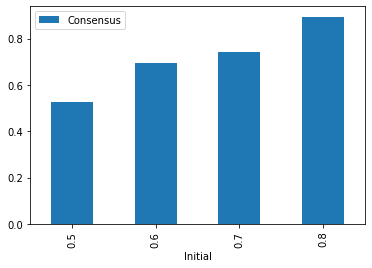

In [183]:
df1[df1['Model'] == 0].plot.bar('Initial', 'Consensus')

<Axes: xlabel='Initial'>

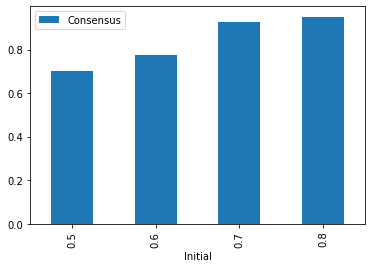

In [184]:
df1[df1['Model'] == 1].plot.bar('Initial', 'Consensus')

<Axes: xlabel='Initial'>

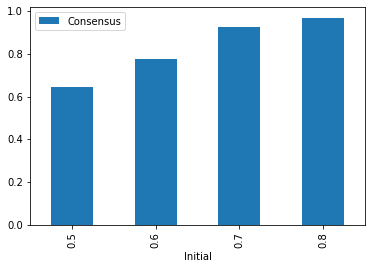

In [185]:
df1[df1['Model'] == 2].plot.bar('Initial', 'Consensus')

NOTE: if a node is taken out (belief set to 0), it will slowly regenerate persuasion. So it spends, regenerates 1. Then it gets set to 0, doesn't spend, regenerates 1. Now it's (0,2) but can be convinced as (1, 2) and start persuading. But if a node is merely unconnected, it doesn't have passive persuasion income. Good or bad?

In [176]:
def runagents2(d, C, p, t, N, j, k, major, minor):
    
    grand_d = d.copy() #np.zeros(np.shape(d))
    
    if len(d[d > 0]) > len(d[d < 0]):
        
        majority = 1
        

    else:
        
        majority = -1
    
    for i in range(N):
        
        if np.sign(d.flat[i]) == majority:
            
            model = major
            

        else:
            
            model = minor
                

        if model == 0 and t[i] == j:

            d1, p = model0b(C, d, p, i)
            

        elif model == 1 and t[i] == j:

            d1, p = model1b(C, d, p, i)

        elif model == 2:
            d1, p = model2b(C, d, p, k, j, i)
        
        # d1 - d is the change between the result of this node's action and the original state

        else:
            d1 = d

        grand_d = grand_d + d1 - d
        C1 = computeC(grand_d, np.transpose(np.where(C == 0)), 0, 0)
        
        #print(len(grand_d[grand_d > 0]))
        

    return C1, grand_d, p

In [177]:
def runsystems2(N, ratio, major, minor, k):

    d = generateBelief(N, 6, ratio)
    C = computeC(d, [], .3, .3)
    p = generatePersuasion(N, 6)

    t = random.choices(range(1, k+1), k = N)

    for j in range(1,k+1):
        C, d, p = runagents2(d, C, p, t, N, j, k, major, minor)
        

    return C, d, p

In [178]:
def replicate2(N, ratio, major, minor, k, runs):

    total_consensus = 0

    for r in range(runs):

        C, d, p = runsystems2(N, ratio, major, minor, k)

        consensus = max(1 - (len(d[d > 0]) / N), (len(d[d > 0]) / N))

        total_consensus += consensus
    
    avg_consensus = total_consensus / runs
    
    return avg_consensus

In [179]:
print(replicate2(16, .5, 0, 1, 3, 1))

0.6875


In [195]:
df1 = pd.DataFrame(columns=['Initial', 'Consensus', 'Majority', 'Minority'])

for a in range(5, 9):
    
    for major in range(0, 3):
        
        for minor in range(0, 3):

            df1.loc[len(df1)] = [a/10, replicate2(16, a/10, major, minor, 3, 10), major, minor]
            print('done with model', major, 'in majority', 'and model', minor, 'in minority', a/10)

done with model 0 in majority and model 0 in minority 0.5
done with model 0 in majority and model 1 in minority 0.5
done with model 0 in majority and model 2 in minority 0.5
done with model 1 in majority and model 0 in minority 0.5
done with model 1 in majority and model 1 in minority 0.5
done with model 1 in majority and model 2 in minority 0.5
done with model 2 in majority and model 0 in minority 0.5
done with model 2 in majority and model 1 in minority 0.5
done with model 2 in majority and model 2 in minority 0.5
done with model 0 in majority and model 0 in minority 0.6
done with model 0 in majority and model 1 in minority 0.6
done with model 0 in majority and model 2 in minority 0.6
done with model 1 in majority and model 0 in minority 0.6
done with model 1 in majority and model 1 in minority 0.6
done with model 1 in majority and model 2 in minority 0.6
done with model 2 in majority and model 0 in minority 0.6
done with model 2 in majority and model 1 in minority 0.6
done with mode

<Axes: xlabel='Initial'>

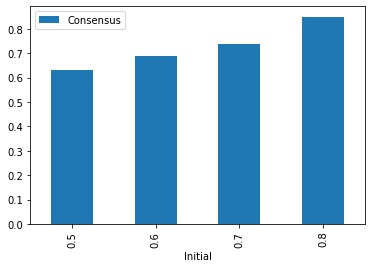

In [196]:
df1[(df1['Majority'] == 0) & (df1['Minority'] == 1)].plot.bar('Initial', 'Consensus')

<Axes: xlabel='Initial'>

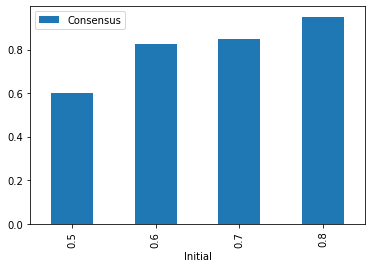

In [197]:
df1[(df1['Majority'] == 1) & (df1['Minority'] == 0)].plot.bar('Initial', 'Consensus')

<Axes: xlabel='Initial'>

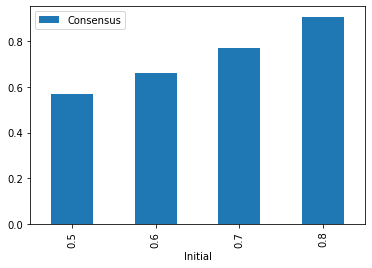

In [198]:
df1[(df1['Majority'] == 0) & (df1['Minority'] == 2)].plot.bar('Initial', 'Consensus')

<Axes: xlabel='Initial'>

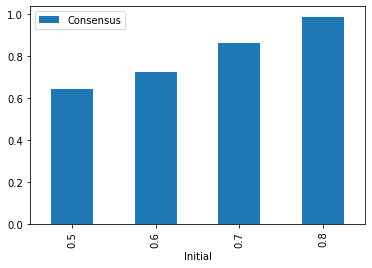

In [199]:
df1[(df1['Majority'] == 2) & (df1['Minority'] == 0)].plot.bar('Initial', 'Consensus')

<Axes: xlabel='Initial'>

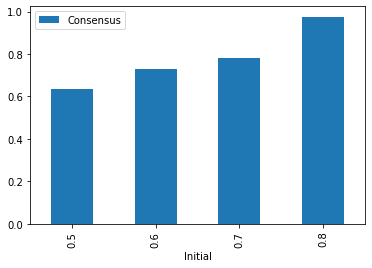

In [200]:
df1[(df1['Majority'] == 2) & (df1['Minority'] == 1)].plot.bar('Initial', 'Consensus')

In [ ]:
def runagents3(d, C, p, t, N, j, k, positive, negative):
    
    grand_d = d.copy() #np.zeros(np.shape(d))
    
    for i in range(N):
        
        if np.sign(d.flat[i]) == 1:
            
            model = positive
            
        else:
            
            model = negative
            

        if model == 0 and t[i] == j:

            d1, p = model0b(C, d, p, i)
            

        elif model == 1 and t[i] == j:

            d1, p = model1b(C, d, p, i)

        elif model == 2:
            d1, p = model2b(C, d, p, k, j, i)
        
        # d1 - d is the change between the result of this node's action and the original state

        else:
            d1 = d

        grand_d = grand_d + d1 - d
        C1 = computeC(grand_d, np.transpose(np.where(C == 0)), 0, 0)
        
        #print(len(grand_d[grand_d > 0]))
        

    return C1, grand_d, p

def runsystems3(N, ratio, positive, negative, k):

    d = generateBelief(N, 6, ratio)
    C = computeC(d, [], .3, .3)
    p = generatePersuasion(N, 6)

    t = random.choices(range(1, k+1), k = N)

    for j in range(1,k+1):
        C, d, p = runagents3(d, C, p, t, N, j, k, major, minor)
        

    return C, d, p

def replicate3(N, ratio, positive, negative, k, runs):

    total_consensus = 0

    for r in range(runs):

        C, d, p = runsystems3(N, ratio, major, minor, k)

        consensus = max(1 - (len(d[d > 0]) / N), (len(d[d > 0]) / N))

        total_consensus += consensus
    
    avg_consensus = total_consensus / runs
    
    return avg_consensus



In [190]:
df1 = pd.DataFrame(columns=['Initial', 'Consensus', 'Positive', 'Negative'])

for a in range(5, 9):
    
    for positive in range(0, 3):
        
        for negative in range(0, 3):

            df1.loc[len(df1)] = [a/10, replicate3(16, a/10, positive, negative, 3, 10), positive, negative]
            print('done with model', positive, 'for positives and model', negative, 'for negatives', a/10)

done with model 0 for positives and model 0 for negatives 0.5
done with model 0 for positives and model 1 for negatives 0.5
done with model 0 for positives and model 2 for negatives 0.5
done with model 1 for positives and model 0 for negatives 0.5
done with model 1 for positives and model 1 for negatives 0.5
done with model 1 for positives and model 2 for negatives 0.5
done with model 2 for positives and model 0 for negatives 0.5
done with model 2 for positives and model 1 for negatives 0.5
done with model 2 for positives and model 2 for negatives 0.5
done with model 0 for positives and model 0 for negatives 0.6
done with model 0 for positives and model 1 for negatives 0.6
done with model 0 for positives and model 2 for negatives 0.6
done with model 1 for positives and model 0 for negatives 0.6
done with model 1 for positives and model 1 for negatives 0.6
done with model 1 for positives and model 2 for negatives 0.6
done with model 2 for positives and model 0 for negatives 0.6
done wit

<Axes: xlabel='Initial'>

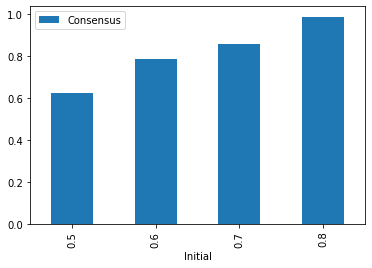

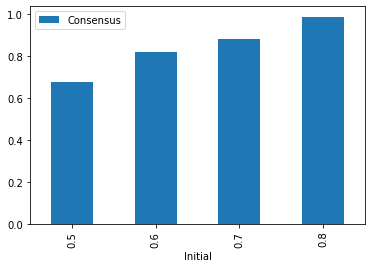

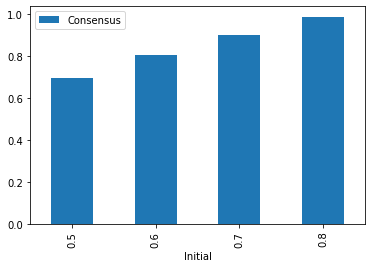

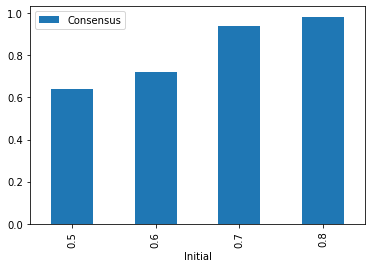

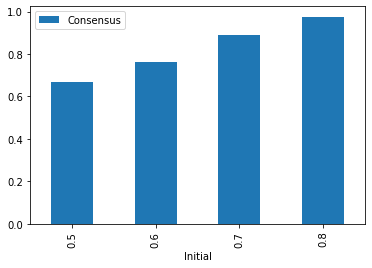

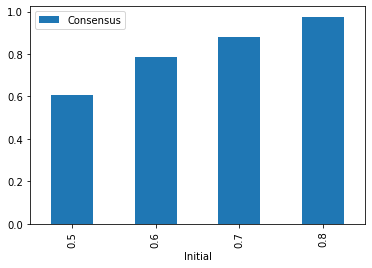

In [192]:
df1[(df1['Positive'] == 0) & (df1['Negative'] == 1)].plot.bar('Initial', 'Consensus')
df1[(df1['Positive'] == 1) & (df1['Negative'] == 0)].plot.bar('Initial', 'Consensus')
df1[(df1['Positive'] == 0) & (df1['Negative'] == 2)].plot.bar('Initial', 'Consensus')
df1[(df1['Positive'] == 2) & (df1['Negative'] == 0)].plot.bar('Initial', 'Consensus')
df1[(df1['Positive'] == 1) & (df1['Negative'] == 2)].plot.bar('Initial', 'Consensus')
df1[(df1['Positive'] == 2) & (df1['Negative'] == 1)].plot.bar('Initial', 'Consensus')

The next step for the model is to have things run iteratively over k rounds. Right now, nodes act according to their neighbors. These actions change the belief of neighbors, which should change how those neighbors act in the next round.

Model 2 is the same as Model 1, except that it sends p/k persuasion. This makes Model 2 more "intelligent" than Model 1, in that it understands that there will be a number of rounds and it plans accordingly.

To run Model 2, we simply run Model 1 but with p/k instead of p persuasion.

------------------------------------------------------------------------------------

This runs models asymmetrically based on their belief.

In [31]:
def runmodel_a(model, runs, N, ratio):

    total_consensus = 0
    
    for j in range(runs):
    
        d = generateBelief(N, 6, ratio)
        C = computeC(d, [], .3, .3)
        p = generatePersuasion(N, 6)
        
        grand_d = d.copy() #np.zeros(np.shape(d))
        
        for i in range(N):

            if np.sign(d.flat[i]) == 1:

                C1, d1, p1 = model0(C, d, p, i)
                
            else:

                C1, d1, p1 = model1(C, d, p, i)
            
            # d1 - d is the change between the result of this node's action and the original state
            
            grand_d = grand_d + d1 - d
            
            #print(len(grand_d[grand_d > 0]))
            
        
        consensus = 1 - (len(grand_d[grand_d > 0]) / N)
        
        print('Consensus ended up at', max(consensus, 1 - consensus), 'for run', j)

        total_consensus += max(consensus, 1 - consensus)

    avg_consensus = total_consensus / runs

    print('Average consensus for model', model, 'over', runs, 'runs is', avg_consensus)

    return max(consensus, 1 - consensus), avg_consensus

In [6]:
consensus, mean = runmodel_a(1, 100, 100, .5)

NameError: name 'runmodel_a' is not defined